In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMRegressor
from scipy.stats import randint, uniform
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn import linear_model
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [2]:
df_previous_train = pd.read_table("2023-02-01_4_train.txt")
df_previous_test = pd.read_table("2023-02-01_4_test.txt")
df_recent = pd.read_table("2023-02-01_4_future.txt")
df_previous_train.insert(18, 'data_class', 'train')
df_previous_test.insert(18, 'data_class', 'test')
df_recent.insert(18, 'data_class', 'future')

In [3]:
df = pd.concat([df_previous_train, df_previous_test, df_recent], ignore_index=True) # the lengths of all seqs are equal (MSA)
df

,group,data_group,outcome,seq,date.first,clade,country,count_x,count_hyphen,task_id,seq_id,major_group,major_group2,weight,split_class,hap_Id,Nextclade_pango,haplotype,data_class
0,fitness,fitness_UK,0.115971,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,2021-01-06 00:00:00,20I,UK,0,3,1221,12160,fitness,fitness,1,fitness_UK_20I,hap_85676,B.1.1.7,"S:N501Y, S:A570D, S:D614G, S:P681H, S:T716I, S...",train
1,fitness,fitness_USA,0.696820,MFVFLVLLPLVSSQCVNLITRTQ---SYTNSFTRGVYYPDKVFRSS...,2022-06-20 00:00:00,22B,USA,0,5,1222,2258,fitness,fitness_recent,2,fitness_USA_22B,hap_161646,BE.1,"S:T19I, S:A27S, S:G142D, S:V213G, S:G339D, S:S...",train
2,fitness,fitness_Denmark,0.561164,MFVFLVLLPLVSSQCVNLITRTQ---SYTNSFTRGVYYPDKVFRSS...,2022-01-10 00:00:00,21L,Denmark,1,3,1210,6485,fitness,fitness_recent,2,fitness_Denmark_21L,hap_174049,BA.2,"S:T19I, S:A27S, S:G142D, S:V213G, S:G339D, S:S...",train
3,fitness,fitness_Brazil,0.401819,MFVFLVLLPLVSSQCVNFINRTQLPSAYTNSFTRGVYYPDKVFRSS...,2021-02-04 00:00:00,20J,Brazil,0,0,1208,867,fitness,fitness,1,fitness_Brazil_20J,hap_55907,P.1.14,"S:L18F, S:T19I, S:T20N, S:P26S, S:D138Y, S:R19...",train
4,fitness,fitness_India,0.418099,MFVFLVLLPLVSSQCVNLRTRTQLPPAYTNSFTRGVYYPDKVFRSS...,2021-06-22 00:00:00,21J,India,2,2,1213,9315,fitness,fitness,1,fitness_India_21J,hap_331304,AY.36,"S:T19R, S:T95I, S:R158G, S:L452R, S:T478K, S:D...",train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21293,fitness,fitness_France,0.902802,MFVFLVLLPLVSSQCVNLITRTQ---SYTNSFTRGVYYPDKVFRSS...,2023-05-11 00:00:00,23E,France,0,5,1211,3392,fitness,fitness_recent,2,fitness_France_23E,hap_219267,GE.1,"S:T19I, S:A27S, S:V83A, S:G142D, S:H146Q, S:Q1...",future
21294,fitness,fitness_UK,0.849067,MFVFLVLLPLVSSQCVNLITRTQ---SYTNSFTRGVYYPDKVFRSS...,2023-02-11 00:00:00,23A,UK,0,4,1221,3316,fitness,fitness_recent,2,fitness_UK_23A,hap_239211,XBB.1.5,"S:T19I, S:A27S, S:V83A, S:T95N, S:G142D, S:H14...",future
21295,fitness,fitness_Sweden,0.854432,MFVFLVLLPLVSSQCVNLITRTQ---SYTNSFTRGVYYPDKVFRSS...,2023-03-07 00:00:00,23A,Sweden,0,4,1219,3726,fitness,fitness_recent,2,fitness_Sweden_23A,hap_224638,EU.1.1.2,"S:T19I, S:A27S, S:V83A, S:G142D, S:H146Q, S:Q1...",future
21296,fitness,fitness_USA,0.831360,MFVFLVLLPLVSSQCVNLITRTQ---XYTNSFTRGVYYPDKVFRSS...,2023-03-10 00:00:00,23A,USA,3,4,1222,7268,fitness,fitness_recent,2,fitness_USA_23A,hap_251510,XBB.1.5,"S:T19I, S:V83A, S:V143D, S:H146Q, S:Q183E, S:V...",future


In [4]:
rows_with_nan = df[df.isna().any(axis=1)]

if not rows_with_nan.empty:
    print("Rows containing NaN values：")
    print(rows_with_nan)
else:
    print("Rows that do not contain a NaN value")

# All sequences with nan value are original variant, and have the same sequence

Rows containing NaN values：
         group           data_group   outcome  \
1971   fitness      fitness_Germany  0.230507   
2084   fitness      fitness_Belgium  0.174528   
4812   fitness        fitness_Spain  0.283228   
8347   fitness  fitness_Netherlands  0.093294   
9738   fitness      fitness_Denmark -0.005987   
10365  fitness    fitness_Australia  0.146757   
12207  fitness        fitness_India  0.337346   
13260  fitness        fitness_Japan  0.113861   
13620  fitness       fitness_Canada  0.172450   
14406  fitness        fitness_Italy  0.228545   
16483  fitness          fitness_USA  0.153082   
16700  fitness  fitness_South Korea  0.202106   
17413  fitness       fitness_Brazil  0.475166   
17963  fitness  fitness_Switzerland  0.149894   
18474  fitness       fitness_Sweden  0.110148   
19015  fitness       fitness_France  0.221555   
19515  fitness           fitness_UK -0.018577   

                                                     seq           date.first  \
1971   M

In [5]:
haplotypes = df["haplotype"]
all_haplotypes = []

# Add the haplotype of each variant separately to the list all_haplotypes
for i in range(len(haplotypes)):
    if pd.notna(haplotypes[i]): # For variants other than 19A
        haplotype = haplotypes[i].split(", ")
        all_haplotypes.append(haplotype)
    else: # For variant 19A
        all_haplotypes.append(["nan"])

In [6]:
flat_haplotype = [item for sublist in all_haplotypes for item in sublist] # Turn multi-dimensional all_haplotypes to one-dimensioanl
substitutions = set(flat_haplotype) # Identify all substitutions without repetition
substitutions = list(substitutions)

In [7]:
# Construct the substitution matrix, columns are the name of substitutions, rows are different variants, 1 means the substitution happend.
substitution_matrix = np.zeros((len(all_haplotypes), len(substitutions)))
                              
for i in range(len(substitutions)):
    for j in range(len(all_haplotypes)):
        if substitutions[i] in all_haplotypes[j]:
            substitution_matrix[j][i] = 1

In [8]:
df_substitution = pd.DataFrame(substitution_matrix, columns=substitutions, index=list(df["clade"]))
df_substitution["country"] = list(df["country"])
onehot_country = pd.get_dummies(df_substitution["country"]).astype(int) # One-hot Encoding of country names
df_substitution = pd.concat([df_substitution, onehot_country], axis=1)
del df_substitution["country"]
df_substitution["data_class"] = list(df["data_class"])
df_substitution["outcome"] = list(df["outcome"])

In [9]:
df_substitution

,S:A829T,S:W152G,S:N856S,S:A623T,S:E132K,S:V483-,S:E1144Q,S:N211Y,S:K1038R,S:A1016T,...,Japan,Netherlands,South Korea,Spain,Sweden,Switzerland,UK,USA,data_class,outcome
20I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,train,0.115971
22B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,train,0.696820
21L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,train,0.561164
20J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,train,0.401819
21J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,train,0.418099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,future,0.902802
23A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,future,0.849067
23A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,future,0.854432
23A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,future,0.831360


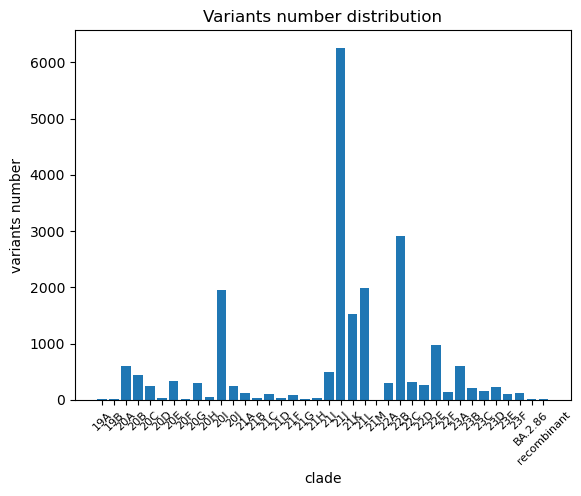

In [10]:
counts = df_substitution.index.value_counts().sort_index()
plt.bar(counts.index,counts.values)
plt.xticks(fontsize=8, rotation=45)
plt.title("Variants number distribution")
plt.xlabel("clade")
plt.ylabel("variants number")
plt.show()

In [11]:
train_df = df_substitution[df_substitution['data_class'] == 'train']
test_df = df_substitution[df_substitution['data_class'] == 'test']
recent_df = df_substitution[df_substitution['data_class'] == 'future']
test_plus_recent_df = pd.concat([test_df, recent_df]) # Concate the test set in the previous dataset and the recent dataset to get a whole test set

# Labels and features of training set
train_labels = train_df["outcome"]
train_features = train_df.drop(["outcome","data_class"], axis=1)
# Labels and features of old test set
test_labels = test_df["outcome"]
test_features = test_df.drop(["outcome","data_class"], axis=1)
# Labels and features of recent set
recent_labels = recent_df["outcome"]
recent_features = recent_df.drop(["outcome","data_class"], axis=1)
# Labels and features of whole test set
test_plus_recent_labels = test_plus_recent_df["outcome"]
test_plus_recent_features = test_plus_recent_df.drop(["outcome","data_class"], axis=1)

print(train_features.shape)
print(test_features.shape)
print(recent_features.shape)
print(test_plus_recent_features.shape)

(16329, 2209)
(4067, 2209)
(902, 2209)
(4969, 2209)


# Feature Selection

In [12]:
# Use random Forest to do feature selection
rf = RandomForestRegressor(n_estimators = 20, random_state = 42)
rf.fit(train_features, train_labels)
    
importances = list(rf.feature_importances_) # Obtain the list of importance of each feature
feature_list = list(train_features.columns) # Obtain the list of features
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(feature_list, importances)] # Get (feature, importance) tuple
feature_importances = sorted(feature_importances, key= lambda x: x[1], reverse = True) # Rank features according to importance
    
selected_features = feature_importances[:200] # Select most important 200 features in the format of (feature, importance) tuple

for i in range(len(selected_features)):
    selected_features[i] = list(selected_features[i])[0] # Convert (feature, importance) tuple into feature name
    
print(selected_features)

['S:N969K', 'S:Q493R', 'UK', 'S:P681R', 'Denmark', 'S:N460K', 'USA', 'S:L981F', 'S:N501Y', 'S:N856K', 'Brazil', 'S:V213G', 'Spain', 'S:F486P', 'S:P681H', 'S:G496S', 'India', 'S:R346T', 'Canada', 'Japan', 'S:T547K', 'Germany', 'S:L452Q', 'Netherlands', 'S:T478K', 'S:L452R', 'S:E484K', 'S:T95I', 'Italy', 'S:G142D', 'S:R346K', 'S:V143-', 'Switzerland', 'S:D950N', 'France', 'S:A222V', 'Sweden', 'S:F486V', 'South Korea', 'S:F157L', 'S:Y145H', 'S:Y145D', 'S:F157-', 'Belgium', 'S:V3G', 'S:K417N', 'S:N658S', 'S:K444T', 'S:T859N', 'S:Y144-', 'S:K417T', 'Australia', 'S:N450D', 'S:H69-', 'S:N440K', 'S:N211-', 'S:Y505H', 'S:T76I', 'S:R158G', 'S:E156-', 'S:L452M', 'S:Q677H', 'S:V70-', 'S:T376A', 'S:S477N', 'S:L18F', 'S:214:EPE', 'S:D614G', 'S:V1264L', 'S:T19R', 'S:K77T', 'S:Q613H', 'S:R408S', 'S:E484A', 'S:Q498R', 'S:F490S', 'S:R346S', 'S:T716I', 'S:L24S', 'S:A1020S', 'S:L5F', 'S:A67V', 'S:A27S', 'S:Y248S', 'S:H1088Y', 'S:I68T', 'S:S371F', 'S:G75V', 'S:S939F', 'S:Q628K', 'S:N764K', 'S:T719I', 'S:Q6

In [13]:
feature_importances[0:10]

[('S:N969K', 0.7910177247),
 ('S:Q493R', 0.0745836162),
 ('UK', 0.0361074778),
 ('S:P681R', 0.0343120968),
 ('Denmark', 0.0099347409),
 ('S:N460K', 0.0087825692),
 ('USA', 0.0071969247),
 ('S:L981F', 0.004145927),
 ('S:N501Y', 0.0037571547),
 ('S:N856K', 0.0036180172)]

In [14]:
# Only use selected features for further training
train_features = train_features[selected_features]
test_features = test_features[selected_features]
recent_features = recent_features[selected_features]
test_plus_recent_features = test_plus_recent_features[selected_features]

In [15]:
train_features

,S:N969K,S:Q493R,UK,S:P681R,Denmark,S:N460K,USA,S:L981F,S:N501Y,S:N856K,...,S:G1124V,S:Q173H,S:D1259Y,S:V16F,S:L176F,S:K147-,S:V1228L,S:T1027I,S:A694V,S:G1219V
20I,0.0,0.0,1,0.0,0,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22B,1.0,0.0,0,0.0,0,0.0,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21L,1.0,1.0,0,0.0,1,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20J,0.0,0.0,0,0.0,0,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21J,0.0,0.0,0,1.0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22C,1.0,1.0,0,0.0,0,0.0,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20I,0.0,0.0,0,0.0,0,0.0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22B,1.0,0.0,0,0.0,0,0.0,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20A,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Random Forest

In [16]:
# Define the parameter space for random forest
param_space = {
    'n_estimators': Integer(500, 1000),
    'max_depth': Categorical([10, 20, 30, None]),
    'max_features': Categorical(['sqrt', 'log2', None]),
    'min_samples_split': Integer(5, 20),
    'min_samples_leaf': Integer(1, 4),
    'bootstrap': Categorical([True, False])
    }

rf1 = RandomForestRegressor(random_state=42)
# Create a Bayesian search object
bayes_search = BayesSearchCV(
    rf1,
    param_space,
    n_iter=20, # Number of iteration times
    scoring='r2',  # Metric to optimize
    n_jobs=-1,  # Number of jobs to run in parallel
    random_state=42
    )

# Fit the Bayesian search object to the data
bayes_search.fit(train_features, train_labels)
# Print the best score and best parameters
print(bayes_search.best_score_)
print(bayes_search.best_params_)
    
best_params = bayes_search.best_params_
rf1 = RandomForestRegressor(**best_params)      
rf1.fit(train_features, train_labels)

# Create predicted fitness dataframe
predictions = rf1.predict(test_plus_recent_features)
prediction_df_rf = test_plus_recent_features.copy()
prediction_df_rf["outcome"] = test_plus_recent_labels
prediction_df_rf["predicted_outcome"] = predictions
prediction_df_rf["data_class"] = test_plus_recent_df["data_class"]

0.9934491665320003
OrderedDict([('bootstrap', True), ('max_depth', 20), ('max_features', None), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 502)])


In [17]:
test_recent_df_rf = df[df['data_class'].isin(['test', 'future'])].reset_index(drop=True)
test_recent_df_rf["predicted_outcome"] = predictions
file_name = '2023-02-01_4_prediction_rf.csv'
test_recent_df_rf.to_csv(file_name, index=False)

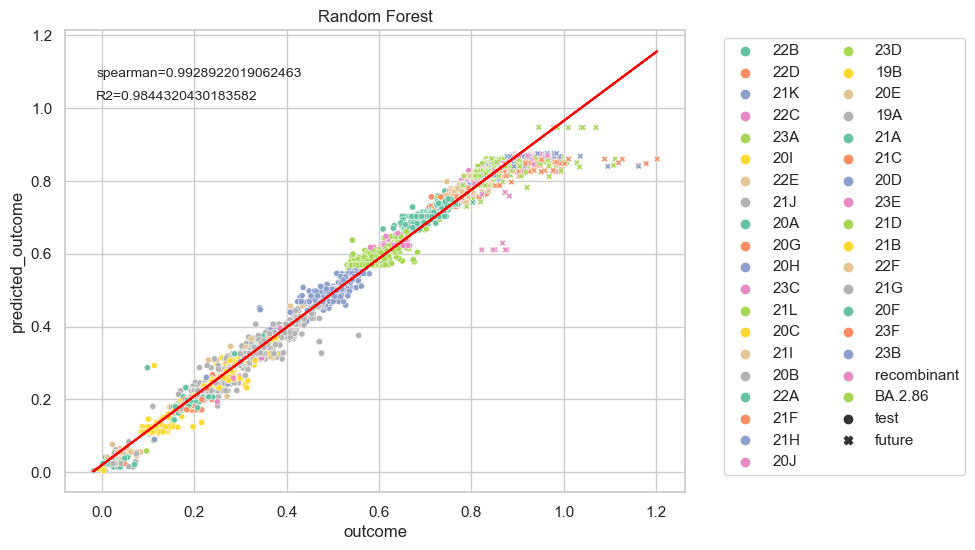

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_rf, y='predicted_outcome', x='outcome', hue=prediction_df_rf.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

r2 = r2_score(prediction_df_rf["outcome"], prediction_df_rf["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
spearman=prediction_df_rf["outcome"].corr(prediction_df_rf["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(spearman), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)
plt.title("Random Forest")

# Plot fit curve by using linear regression
labels = prediction_df_rf["outcome"].tolist()
predictions = prediction_df_rf["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]
plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()

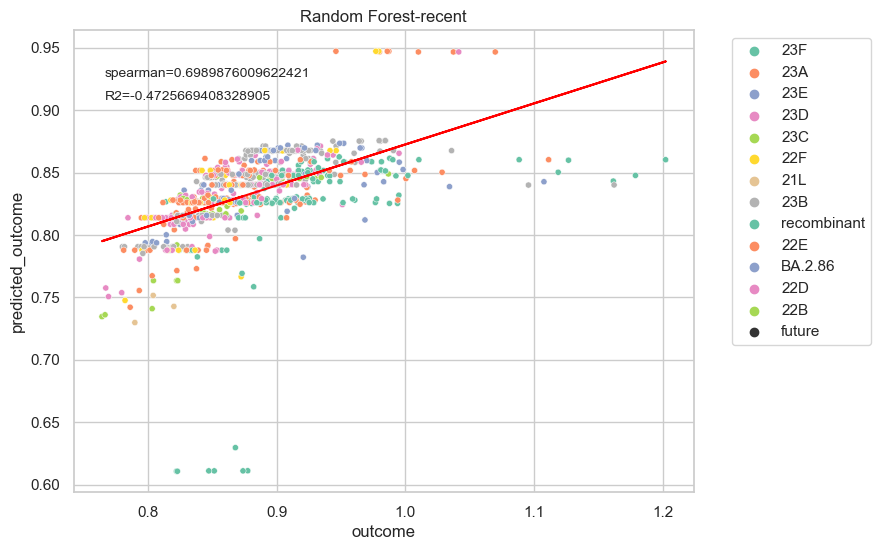

In [19]:
prediction_df_recent = prediction_df_rf[prediction_df_rf['data_class'] == "future"]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_recent, y='predicted_outcome', x='outcome', hue=prediction_df_recent.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

r2 = r2_score(prediction_df_recent["outcome"], prediction_df_recent["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
spearman=prediction_df_recent["outcome"].corr(prediction_df_recent["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(spearman), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)
plt.title("Random Forest-recent")

# Plot fit curve by using linear regression
labels = prediction_df_recent["outcome"].tolist()
predictions = prediction_df_recent["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]
plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()

# LASSO

In [20]:
param_space = {
    'alpha': Real(1e-5, 1e-3, prior="log-uniform"),
    'max_iter': Integer(8000, 10000),
    'tol': Real(1e-5, 1e-3, prior="log-uniform"),
    'selection': Categorical(["cyclic", "random"])
    }

lasso = linear_model.Lasso()
# Create a Bayesian search object
bayes_search = BayesSearchCV(
        lasso,
        param_space,
        n_iter=30,  # Number of parameter settings that are sampled
        scoring='r2',  # Metric to optimize
        n_jobs=-1,  # Number of jobs to run in parallel
        random_state=42
    )
# Fit the Bayesian search object to the data
bayes_search.fit(train_features, train_labels)
# Print the best score and best parameters
print(bayes_search.best_score_)
print(bayes_search.best_params_)
    
best_params = bayes_search.best_params_
lasso = linear_model.Lasso(**best_params)
       
lasso.fit(train_features, train_labels)
predictions = lasso.predict(test_plus_recent_features)

prediction_df_lasso = test_plus_recent_features.copy()
prediction_df_lasso["outcome"] = test_plus_recent_labels
prediction_df_lasso["predicted_outcome"] = predictions
prediction_df_lasso["data_class"] = test_plus_recent_df["data_class"]

0.971991411309919
OrderedDict([('alpha', 1e-05), ('max_iter', 10000), ('selection', 'random'), ('tol', 0.001)])


In [21]:
test_recent_df_lasso = df[df['data_class'].isin(['test', 'future'])].reset_index(drop=True)
test_recent_df_lasso["predicted_outcome"] = predictions
file_name = '2023-02-01_4_prediction_lasso.csv'
test_recent_df_lasso.to_csv(file_name, index=False)

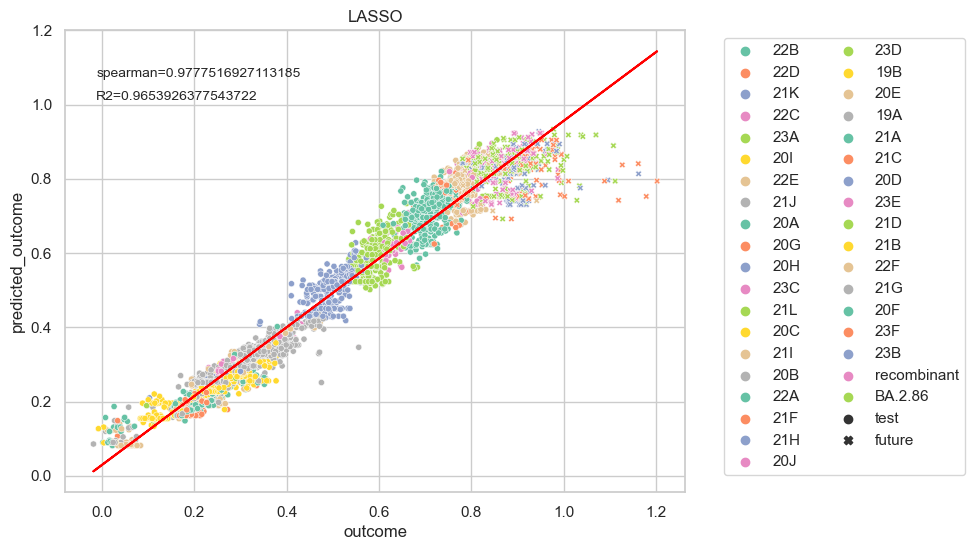

In [22]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_lasso, y='predicted_outcome', x='outcome', hue=prediction_df_lasso.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

r2 = r2_score(prediction_df_lasso["outcome"], prediction_df_lasso["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
spearman=prediction_df_lasso["outcome"].corr(prediction_df_lasso["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(spearman), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)
plt.title("LASSO")

labels = prediction_df_lasso["outcome"].tolist()
predictions = prediction_df_lasso["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]
plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()

0.07319627761059391


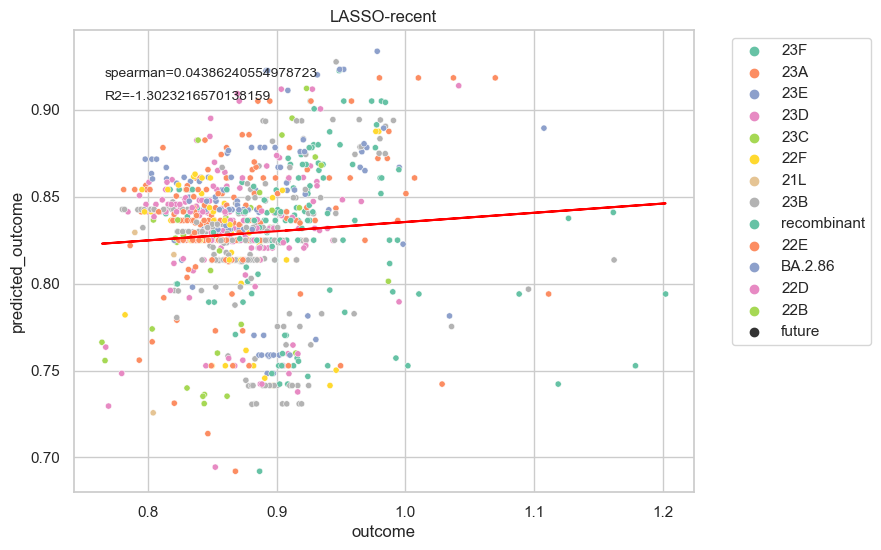

In [23]:
prediction_df_recent = prediction_df_lasso[prediction_df_lasso['data_class'] == "future"]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_recent, y='predicted_outcome', x='outcome', hue=prediction_df_recent.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

r2 = r2_score(prediction_df_recent["outcome"], prediction_df_recent["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
corr=prediction_df_recent["outcome"].corr(prediction_df_recent["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(corr), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)

plt.title("LASSO-recent")
print(prediction_df_recent["outcome"].corr(prediction_df_recent["predicted_outcome"]))

labels = prediction_df_recent["outcome"].tolist()
predictions = prediction_df_recent["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]
plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()

# LightGBM

In [24]:
# Use Bayes search to do finetuning
train_features_nd = np.array(train_features)
test_plus_recent_features_nd = np.array(test_plus_recent_features)

param_space = {
    'max_depth': Integer(30, 50),
    'learning_rate': Real(0.1, 0.4),
    'n_estimators': Integer(800, 1000),
    'min_child_weight': Integer(1, 10),
    'reg_alpha': Real(1e-6, 1e-4),
    'reg_lambda': Real(0, 10),
    'force_row_wise': [True],
    }

lgbr = LGBMRegressor()
# Create a Bayesian search object
opt = BayesSearchCV(
    lgbr,
    param_space,
    n_iter=30,  # Number of iteration times
    scoring='r2',  # Metric to optimize
    n_jobs=-1,  # Number of jobs to run in parallel
    random_state=42
    )
# Fit the Bayesian search object to the data
opt.fit(train_features_nd, train_labels)
# Print the best score and best parameters
print(opt.best_score_)
print(opt.best_params_)
    
best_params = opt.best_params_
lgbr = LGBMRegressor(**best_params)
       
lgbr.fit(train_features_nd, train_labels)
predictions = lgbr.predict(test_plus_recent_features_nd)

prediction_df_lgb = test_plus_recent_features.copy()
prediction_df_lgb["outcome"] = test_plus_recent_labels
prediction_df_lgb["predicted_outcome"] = predictions
prediction_df_lgb["data_class"] = test_plus_recent_df["data_class"]

0.9941300368480512
OrderedDict([('force_row_wise', True), ('learning_rate', 0.2129531684529956), ('max_depth', 49), ('min_child_weight', 3), ('n_estimators', 981), ('reg_alpha', 9.251352967094793e-06), ('reg_lambda', 3.5988430978998536)])


In [25]:
test_recent_df_lgb = df[df['data_class'].isin(['test', 'future'])].reset_index(drop=True)
test_recent_df_lgb["predicted_outcome"] = predictions
file_name = '2023-02-01_4_prediction_lgb.csv'
test_recent_df_lgb.to_csv(file_name, index=False)

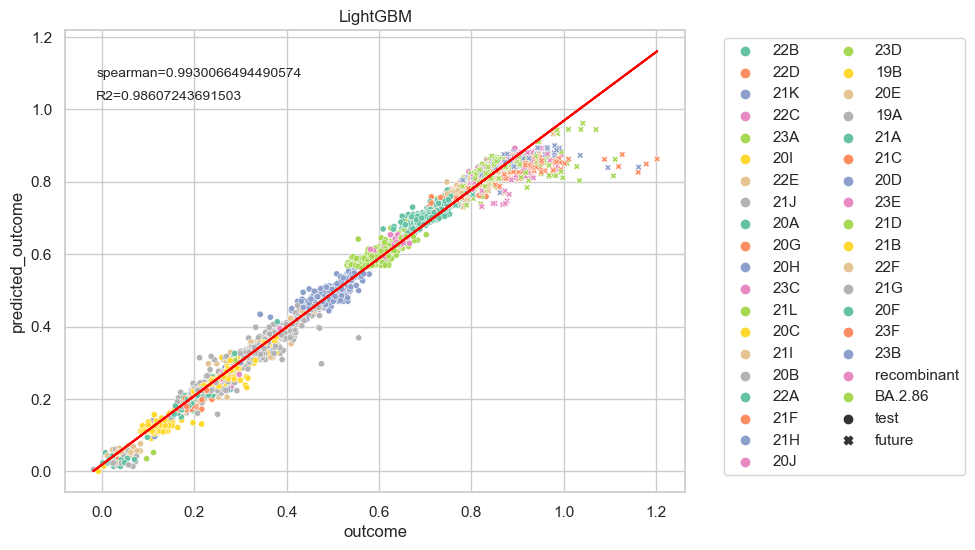

In [26]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_lgb, y='predicted_outcome', x='outcome', hue=prediction_df_lgb.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

r2 = r2_score(prediction_df_lgb["outcome"], prediction_df_lgb["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
spearman=prediction_df_lgb["outcome"].corr(prediction_df_lgb["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(spearman), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)
plt.title("LightGBM")

labels = prediction_df_lgb["outcome"].tolist()
predictions = prediction_df_lgb["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]

plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()

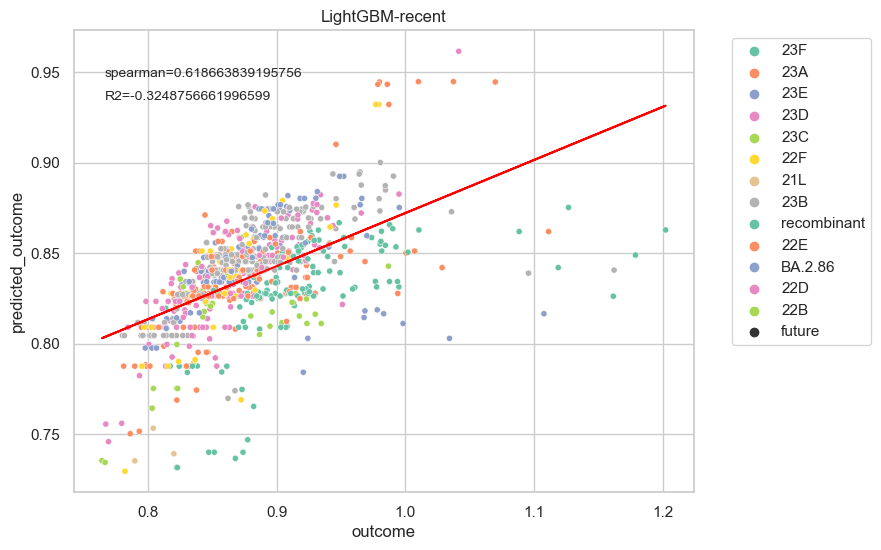

In [27]:
prediction_df_recent = prediction_df_lgb[prediction_df_lgb['data_class'] == "future"]

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=prediction_df_recent, y='predicted_outcome', x='outcome', hue=prediction_df_recent.index, palette='Set2', style = "data_class", s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

r2 = r2_score(prediction_df_recent["outcome"], prediction_df_recent["predicted_outcome"])
plt.annotate("R2={}".format(r2), xy=(0.05,0.85), xycoords="axes fraction", fontsize=10)
spearman=prediction_df_recent["outcome"].corr(prediction_df_recent["predicted_outcome"], method="spearman")
plt.annotate("spearman={}".format(spearman), xy=(0.05,0.9), xycoords="axes fraction", fontsize=10)
plt.title("LightGBM-recent")

labels = prediction_df_recent["outcome"].tolist()
predictions = prediction_df_recent["predicted_outcome"].tolist()
X = [[label] for label in labels]
Y = [[prediction] for prediction in predictions]
reg = LinearRegression().fit(X, Y)
intercept = reg.intercept_[0]
slope = reg.coef_[0][0]
plt.plot(labels, [slope*label+intercept for label in labels], color="red")
plt.show()